In [ ]:
!pip install transformers torch datasets matplotlib scikit-learn

import torch
from transformers import BertTokenizer, BertForNextSentencePrediction, Trainer, TrainingArguments
from datasets import Dataset, load_dataset
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 34.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 87.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 36.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
# Step 1: Dataset
sentences = [
    ("The quick brown fox jumps over the lazy dog.", "The dog was not amused.", 1),
    ("The quick brown fox jumps over the lazy dog.", "I love eating pizza.", 0),
    ("She opened the door.", "She saw her friend standing there.", 1),
    ("She opened the door.", "The sky was blue.", 0),
    ("He went to the store.", "He bought some groceries.", 1),
    ("He went to the store.", "It started raining heavily.", 0)
]
dataset = Dataset.from_dict({
    "sentence1": [s[0] for s in sentences],
    "sentence2": [s[1] for s in sentences],
    "label": [s[2] for s in sentences]
})
split = dataset.train_test_split(test_size=0.2)
train_dataset, test_dataset = split["train"], split["test"]

In [ ]:
# Step 2: Tokenization
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
def tokenize(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True, padding="max_length", max_length=128)
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)
train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

Map:   0%|          | 0/4 [00:00<?, ? examples/s]

Map:   0%|          | 0/2 [00:00<?, ? examples/s]

In [ ]:
# Step 3: Model & Training
model = BertForNextSentencePrediction.from_pretrained("bert-base-uncased")
from transformers import TrainingArguments
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",  # Save at the end of each epoch
)

In [ ]:
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    return {"accuracy": accuracy_score(labels, preds)}
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)
trainer.train()

# Step 4: Evaluation
eval_results = trainer.evaluate()
print(f"\nEvaluation Results: {eval_results}")

Step,Training Loss



Evaluation Results: {'eval_loss': 2.1910364627838135, 'eval_accuracy': 0.5, 'eval_runtime': 0.9243, 'eval_samples_per_second': 2.164, 'eval_steps_per_second': 1.082, 'epoch': 3.0}


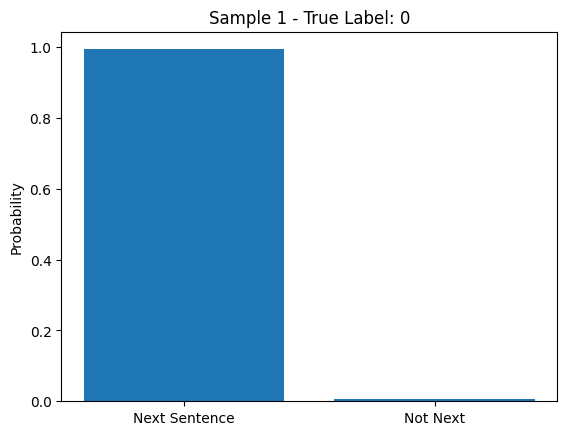

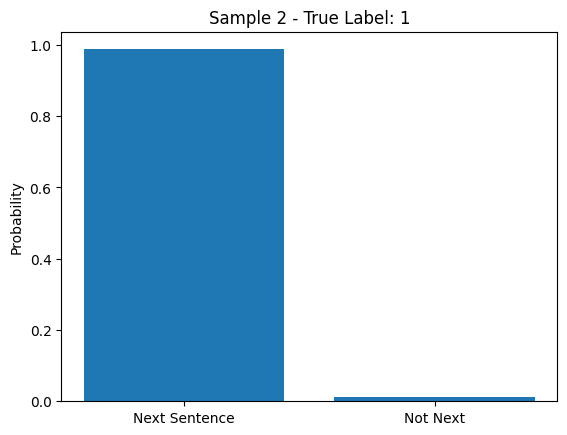

In [ ]:
# Step 6: Prediction Probabilities
predictions = trainer.predict(test_dataset)
probs = torch.softmax(torch.tensor(predictions.predictions), dim=1).numpy()
for i in range(min(5, len(test_dataset))):
    plt.bar(["Next Sentence", "Not Next"], probs[i])
    plt.title(f"Sample {i+1} - True Label: {test_dataset[i]['label']}")
    plt.ylabel("Probability")
    plt.show()
